In [20]:
import os
from glob import glob
import zipfile
import functools

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image

In [21]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import cv2
import pandas as pd
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.utils import CustomObjectScope
from sklearn.metrics import accuracy_score,f1_score,jaccard_score,precision_score,recall_score
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [22]:
import tensorflow as tf

from tensorflow.python.keras import layers
from tensorflow.python.keras import losses
from tensorflow.python.keras import models
from tensorflow.python.keras import backend as K  
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [23]:

from tensorflow.keras.layers import Conv2D,BatchNormalization,Activation,MaxPool2D,Conv2DTranspose,Concatenate,Input,Flatten
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras import backend as K

In [24]:
from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger,ReduceLROnPlateau,EarlyStopping,TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall,Precision


In [25]:
%cd drive/MyDrive/data_semantics/
path = os.getcwd()

[Errno 2] No such file or directory: 'drive/MyDrive/data_semantics/'
/content/drive/MyDrive/data_semantics


In [26]:
def double_conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x


In [27]:
def encoder_block(inputs, num_filters):
    s = double_conv_block(inputs, num_filters)
    p = MaxPool2D((2,2))(s)
    
    return s, p

In [28]:
def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2,2), strides=2, padding="same")(inputs) 
    x = Concatenate()([x,skip_features])
    x = BatchNormalization()(x)                     
    x = Activation("relu")(x)                       
    x = double_conv_block(x,num_filters)

    return x

In [29]:
def build_model_unet(input_shape):
    inputs = Input(input_shape)
    
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = double_conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1,1,padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="UNET")
    return model

model = build_model_unet((256,256,3))
model.summary()

Model: "UNET"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_57 (Conv2D)              (None, 256, 256, 64) 1792        input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_66 (BatchNo (None, 256, 256, 64) 256         conv2d_57[0][0]                  
__________________________________________________________________________________________________
activation_66 (Activation)      (None, 256, 256, 64) 0           batch_normalization_66[0][0]     
_______________________________________________________________________________________________

In [30]:
def read(img_path, mask_path):
    x = cv2.imread(img_path, cv2.IMREAD_COLOR)
    y = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    plt.subplot(2, 1, 1)
    plt.imshow(x)
    plt.subplot(2, 1, 2)
    plt.imshow(y,cmap='gray')
    
    plt.show()
        
    y = cv2.resize(y, (16,16))
    return y

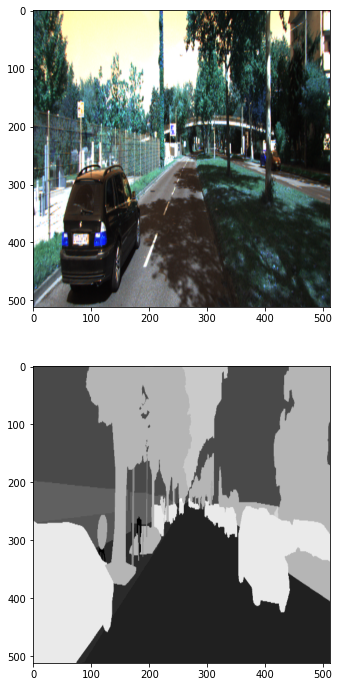

[[11 11 11 21 21 21 21 21 23 23 11 11 11 11 21 21]
 [11 11 11 21 21 21 21 21 23 23 11 11 11 14 21 21]
 [11 11 11 11 21 21 21 21 23 23 11 11 11 21 21 21]
 [11 11 11 11 21 21 21 21 23 23 11 11 11 21 21 21]
 [11 11 11 11 21 21 21 21 23 11 11 11 11 21 21 21]
 [11 11 11 11 21 11 21 21 23 21 11 11 11 21 21 21]
 [13 13 13 11 21 11 21 16 20 21 11 11 11 21 21 21]
 [13 13 13 13 21 13 21 26 26 18 21 21 21 21 21 21]
 [22 26 12 13 21 10 22  8  7  7 26 26 26 26 26 25]
 [26 26 26 14 21 21 21  7  7  7  7 26 26 26 26 26]
 [26 26 26 26 21  8  7  7  7  7  7 26 26 26 21 21]
 [26 26 26 26 21  8  7  7  7  7  7 24 26 26 21 21]
 [26 26 26 26  8  7  7  7  7  7  7  7 26 26  7  7]
 [26 26 26 26  7  7  7  7  7  7  7  7  7  7  7  7]
 [26 26 26  8  7  7  7  7  7  7  7  7  7  7  7  7]
 [26 26 26  7  7  7  7  7  7  7  7  7  7  7  7  7]]


In [31]:
img_path = os.path.join(path, "final_data", "images", "000018_10_1.png")
mask_path = os.path.join(path, "final_data", "masks", "000018_10_1.png")

y = read(img_path, mask_path)
print(y)


In [32]:
def read_mask1(path):
    y = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    plt.imshow(y, cmap="gray")
    for i in range(len(y[:][0])):
        for j in range(len(y[0][:])):
            if y[i][j]>=25:
                y[i][j]=1
            else:
                y[i][j]=0
    plt.imshow(y,cmap="gray")
    y = cv2.resize(y, (16,16))
    return y

[[1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0]
 [1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0]
 [1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1]
 [1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1]]


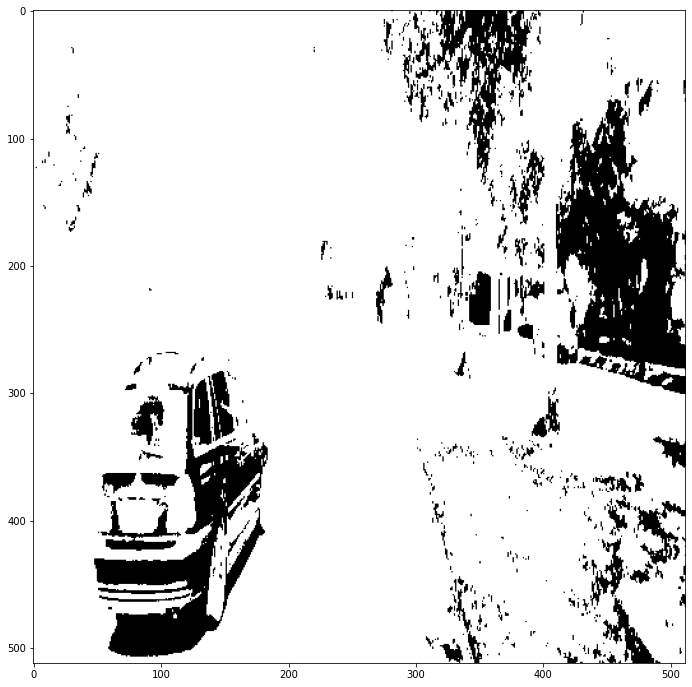

In [33]:
y=read_mask1(img_path)
print(y)


In [34]:
h, w = 256, 256

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def shuffling(x,y):
    x,y = shuffle(x,y,random_state=105)
    
def read_image(path):
    path = path.decode()
    x = cv2.imread(path,cv2.IMREAD_COLOR)
    x = cv2.resize(x,(w,h))
    x= x/255.0 
    x = x.astype(np.float32)
    return x

def read_mask(path):
    path = path.decode()
    y = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    y = cv2.resize(y, (w, h))
    for i in range(len(y[:][0])):
        for j in range(len(y[0][:])):
            if y[i][j]>=25:    # Car = 1
                y[i][j]=1
            else:              #other = 0
                y[i][j]=0
    y = y.astype(np.float32)
    y = np.expand_dims(y, axis=-1)
    return y

def tf_parse(x_path, y_path):  # make tf tensor of image matrix
    def _parse(x_path,y_path):    # extract image
        x = read_image(x_path)
        y = read_mask(y_path)
        return x , y
    
    x,y = tf.numpy_function(_parse,[x_path,y_path],[tf.float32, tf.float32])
    x.set_shape([h,w,3])
    y.set_shape([h,w,1])
    return x,y

def tf_dataset(x_path, y_path, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x_path,y_path))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(4)
    return dataset

def load_data(path, split=0.2):
    # important
    images = sorted(glob(os.path.join(path, "images", "*.png")))
    masks = sorted(glob(os.path.join(path, "masks", "*.png")))
    
    size = int(len(images)*split)
    
    train_x,valid_x = train_test_split(images, test_size = split, random_state = 105)
    train_y,valid_y = train_test_split(masks, test_size = split, random_state = 105)
    return (train_x, train_y), (valid_x, valid_y)

In [35]:
np.random.seed(105)
tf.random.set_seed(105)

# directory to save files
create_dir("new_files")

# hyperparameters
batch_size = 3
lr = 1e-4
num_epochs = 30
model_path ="new_files/model.h5"
csv_path="new_files/data.csv"

# Dataset
dataset_path = os.path.join(path, "final_data")

(train_x, train_y), (valid_x, valid_y) = load_data(dataset_path,0.2)
train_x, train_y = shuffle(train_x, train_y)


print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Valid: {len(valid_x)} - {len(valid_y)}")


train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

train_steps = (len(train_x)//batch_size)
valid_steps = (len(valid_x)//batch_size)

if len(train_x) % batch_size != 0:
    train_steps +=1
    
if len(valid_x) % batch_size != 0:
    valid_steps += 1
    
# train_steps=int(np.ceil(num_train_examples / float(batch_size)))

Train: 728 - 728
Valid: 182 - 182


In [36]:
smooth = 1e-15
def iou(y_true,y_pred):         # converting simple function to tensor
    def f(y_true,y_pred):
        intersection = (y_true*y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + smooth) / (union + smooth)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f,[y_true,y_pred],tf.float32)

def dice_coef(y_true,y_pred):      # build function using tensor
    y_true = Flatten()(y_true)     # make tensor here itself
    y_pred = Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true*y_pred)
    return (2.*intersection + smooth)/(tf.reduce_sum(y_true)+tf.reduce_sum(y_pred)+smooth)

# Using cross entropy is more of a proxy which is easier to maximize
def dice_loss(y_true,y_pred):       # perform better at class imbalanced problems
    return 1.0 - dice_coef(y_true,y_pred)

# we'll use a specialized loss function that combines binary cross entropy and our dice loss ##################
def bce_dice_loss(y_true,y_pred):
    loss=losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

In [37]:
model = build_model_unet((h,w,3))
metrics = [dice_coef, iou, Recall(), Precision()]
model.compile(loss=bce_dice_loss, optimizer=Adam(lr), metrics=metrics)


callbacks =[
        ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
        CSVLogger(csv_path),
        TensorBoard(),
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
]

history=model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=valid_dataset,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks
)

Epoch 1/30
243/243 [==============================] - 236s 954ms/step - loss: 1.1432 - dice_coef: 0.1569 - iou: 0.0862 - recall_2: 0.2015 - precision_2: 0.2248 - val_loss: 1.1884 - val_dice_coef: 0.0853 - val_iou: 0.0449 - val_recall_2: 0.0000e+00 - val_precision_2: 0.0000e+00

Epoch 00001: val_loss improved from inf to 1.18842, saving model to new_files/model.h5
Epoch 2/30
243/243 [==============================] - 227s 934ms/step - loss: 1.0305 - dice_coef: 0.2134 - iou: 0.1208 - recall_2: 0.2882 - precision_2: 0.2918 - val_loss: 1.1028 - val_dice_coef: 0.1573 - val_iou: 0.0873 - val_recall_2: 0.1500 - val_precision_2: 0.2631

Epoch 00002: val_loss improved from 1.18842 to 1.10277, saving model to new_files/model.h5
Epoch 3/30
243/243 [==============================] - 232s 955ms/step - loss: 0.9909 - dice_coef: 0.2423 - iou: 0.1397 - recall_2: 0.3263 - precision_2: 0.3127 - val_loss: 1.0691 - val_dice_coef: 0.2251 - val_iou: 0.1305 - val_recall_2: 0.3692 - val_precision_2: 0.2479

E